In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5



--2020-02-10 14:26:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.175.48, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.175.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  11.2MB/s    in 7.6s    

2020-02-10 14:26:22 (11.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

In [3]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

pre_trained_model.summary()

last layer output shape: (None, 7, 7, 768)
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________

In [5]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=1e-4),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [6]:
!wget --no-check-certificate \
            https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
    

--2020-02-10 14:26:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.175.48, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.175.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  11.2MB/s    in 6.0s    

2020-02-10 14:26:51 (11.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_datagen = ImageDataGenerator( rescale = 1./255.,
                                  rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1./255.)   

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   target_size = (150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size = 20,
                                                       class_mode = 'binary',
                                                       target_size = (150,150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit_generator(
             train_generator,
             validation_data = validation_generator,
             steps_per_epoch = 100,
             epochs = 20,
            validation_steps = 50,
            verbose =2 )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 - 17s - loss: 0.4862 - acc: 0.7780 - val_loss: 0.6568 - val_acc: 0.8540
Epoch 2/20
100/100 - 14s - loss: 0.3761 - acc: 0.8340 - val_loss: 0.3784 - val_acc: 0.9200
Epoch 3/20
100/100 - 14s - loss: 0.3604 - acc: 0.8400 - val_loss: 0.2459 - val_acc: 0.9460
Epoch 4/20
100/100 - 14s - loss: 0.3046 - acc: 0.8675 - val_loss: 0.3178 - val_acc: 0.9420
Epoch 5/20
100/100 - 14s - loss: 0.3345 - acc: 0.8615 - val_loss: 0.2069 - val_acc: 0.9560
Epoch 6/20
100/100 - 14s - loss: 0.2977 - acc: 0.8775 - val_loss: 0.3587 - val_acc: 0.9390
Epoch 7/20
100/100 - 14s - loss: 0.3023 - acc: 0.8735 - val_loss: 0.5775 - val_acc: 0.9260
Epoch 8/20
100/100 - 14s - loss: 0.2965 - acc: 0.8760 - val_loss: 0.3706 - val_acc: 0.9500
Epoch 9/20
100/100 - 14s - loss: 0.2796 - acc: 0.8870 - val_loss: 0.3822 - val_acc: 0.9490
Epoch 10/20


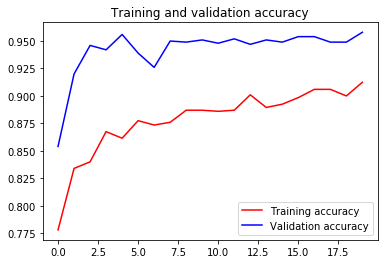

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()